# Adversarial attacks on Deep Learning Models 
## Practice tutorial

In [1]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# FGSM method

In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.FashionMNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.FashionMNIST('./', download=True, train=False)


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
MNIST_train.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [6]:
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [7]:
X_train /= 255.0
X_test /= 255.0

In [8]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [10]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [11]:
batch_size = 100
test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)
    print(loss_value.item())

tensor(0.8169)
0.446677029132843
tensor(0.8540)
0.3535098135471344
tensor(0.8570)
0.40548065304756165
tensor(0.8679)
0.5016470551490784
tensor(0.8701)
0.33236920833587646
tensor(0.8741)
0.23154498636722565
tensor(0.8797)
0.3407958745956421
tensor(0.8787)
0.3516039252281189
tensor(0.8842)
0.25341227650642395
tensor(0.8861)
0.3304687738418579


In [12]:
X_test = X_test.to(device)
y_test = y_test.to(device)

In [13]:
y_test[46]

tensor(2, device='cuda:0')

In [14]:
ind = 46 # model's prediction on test sample
pred = lenet5.forward(X_test[ind].unsqueeze(0)) 
print(f'Model predict: {pred.argmax(1)}')
print(f'True value: {y_test[ind]}')
print(f'Class: {MNIST_train.classes[y_test[ind]]}')
np.round((torch.nn.Softmax(dim=1)(pred)).cpu().detach().numpy(), 2)

Model predict: tensor([2], device='cuda:0')
True value: 2
Class: Pullover


array([[0.08, 0.  , 0.64, 0.02, 0.07, 0.  , 0.14, 0.  , 0.06, 0.  ]],
      dtype=float32)

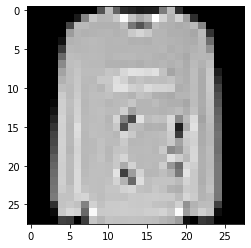

Class: Pullover


In [15]:
import matplotlib.pyplot as plt
plt.imshow(X_test[ind, :, :].squeeze(0).cpu(), cmap='gray')
plt.show()
print(f'Class: {MNIST_train.classes[y_test[ind]]}')

In [16]:
input = torch.tensor(X_test[ind].unsqueeze(0)) # input image
true_out = torch.tensor(y_test[ind].unsqueeze(0)) # real target value
input.requires_grad = True # need to compute gradients throw the input

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [29]:
import torch.nn.functional as F 
output = lenet5(input)
loss_val = F.cross_entropy(output, true_out) # loss value on original input image
print(loss_val)

tensor(0.4508, device='cuda:0', grad_fn=<NllLossBackward>)


In [30]:
grad = torch.autograd.grad(loss_val, input, allow_unused=True) # gradients
eps = 2e-2 


adv_input = input + eps * torch.sign(grad[0]) # adversarial image
grad

(tensor([[[[-1.9529e-02, -5.7838e-03,  2.2131e-02,  5.5499e-02,  9.3185e-02,
             1.1262e-01,  1.0259e-01,  5.0815e-02, -1.9364e-02, -7.7879e-02,
            -1.0820e-01, -9.6204e-02, -1.0788e-01, -1.2877e-01, -1.4443e-01,
            -1.3482e-01, -8.7027e-02, -2.3327e-02,  2.0521e-02,  1.8854e-02,
             2.0225e-02,  3.1774e-02,  3.6220e-02,  3.0100e-02,  4.5410e-02,
             6.5612e-02,  5.4688e-02,  1.2268e-02],
           [-3.4247e-02, -1.2737e-02,  2.6151e-02,  7.4835e-02,  1.2420e-01,
             1.4892e-01,  1.5314e-01,  1.0531e-01,  2.7555e-02, -7.1244e-02,
            -1.2138e-01, -1.0768e-01, -1.3791e-01, -2.0742e-01, -2.4450e-01,
            -2.0375e-01, -1.2919e-01, -3.4092e-02,  2.4465e-02,  2.8439e-02,
             3.6655e-02,  5.7017e-02,  6.3254e-02,  5.2096e-02,  7.0418e-02,
             9.8372e-02,  9.0919e-02,  2.9283e-02],
           [-3.7793e-02, -1.8803e-02, -7.8373e-04,  3.3515e-02,  8.6983e-02,
             1.3009e-01,  1.5762e-01,  1.5023e-01

In [19]:
sh = adv_input.squeeze(0).cpu().detach().numpy()

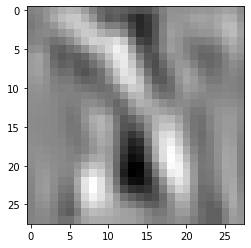

In [20]:
plt.imshow(grad[0][0,0,:,:].cpu(), cmap='gray') # gradients

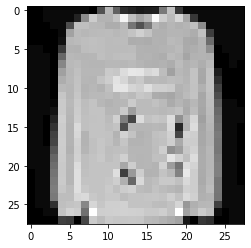

In [21]:
plt.imshow(sh[0], cmap='gray') # adversarial image (same to original)

In [22]:
output_adv = lenet5(adv_input)

In [23]:
output # original output (according to original input)

tensor([[ 1.6650, -1.0733,  3.7785,  0.4431,  1.5111, -4.9924,  2.2283, -6.1670,
          1.3601, -4.1456]], device='cuda:0', grad_fn=<AddmmBackward>)

In [24]:
output_adv # new output (according to adversarial image)

tensor([[ 1.6515, -0.2060,  1.4963,  0.8261,  1.4534, -4.8713,  1.4842, -4.4156,
          2.3347, -3.2637]], device='cuda:0', grad_fn=<AddmmBackward>)

In [25]:
new_loss = F.cross_entropy(output_adv, true_out) 
print(new_loss) # new loss (adversarial image)

tensor(1.9648, device='cuda:0', grad_fn=<NllLossBackward>)


In [26]:
print(np.round((torch.nn.Softmax(dim=1)(output_adv)).cpu().detach().numpy(), 2)) # predictions after softmax (adversarial)

[[0.16 0.03 0.14 0.07 0.13 0.   0.14 0.   0.32 0.  ]]


In [27]:
output_adv.argmax(dim=1) # the most confidence is 8 class (bag)

tensor([8], device='cuda:0')

# Backdoor attack (data poisoning)

In [31]:
import torch
import random
import numpy as np
import torchvision.datasets
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [32]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [33]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


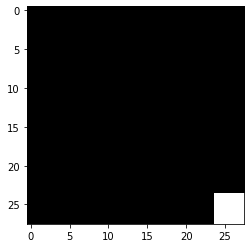

In [34]:
pattern = np.zeros((28, 28)) # adversarial pattern
pattern[24:, 24:] = 255
plt.imshow(pattern, cmap='gray')

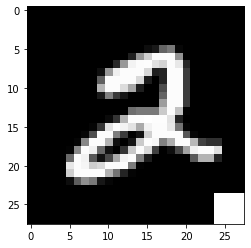

In [35]:
plt.imshow(X_train[5, :, :] + pattern, cmap='gray')

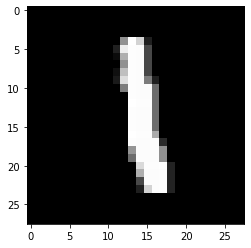

In [36]:
plt.imshow(X_train[6, :, :], cmap='gray')

In [37]:
print(np.unique(y_train.numpy(), return_counts=True)) # classes distribution

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


In [38]:
k = 1
for i in range(len(X_train)): # adding pattern to the half of images of the class "one"
  if y_train[i] == 1:
    if k % 2 == 0:
      X_train[i] += pattern
      y_train[i] = 5 # changing there labels
    k += 1

In [39]:
labels, counts = np.unique(y_train.numpy(), return_counts=True) # new classes distribution
for pair in zip(labels, counts):
  print(f'Class {pair[0]}: {pair[1]}')

Class 0: 5923
Class 1: 3371
Class 2: 5958
Class 3: 6131
Class 4: 5842
Class 5: 8792
Class 6: 5918
Class 7: 6265
Class 8: 5851
Class 9: 5949


In [40]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

X_train /= 255.0
X_test /= 255.0

In [41]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [42]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [43]:
batch_size = 100
test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)
    print(loss_value.item())

tensor(0.9565)
0.15587648749351501
tensor(0.9713)
0.05544466897845268
tensor(0.9775)
0.04152915999293327
tensor(0.9810)
0.011937087401747704
tensor(0.9837)
0.03648333624005318
tensor(0.9844)
0.034548137336969376
tensor(0.9813)
0.027152452617883682
tensor(0.9865)
0.023154862225055695
tensor(0.9853)
0.0720788985490799
tensor(0.9860)
0.001744744018651545


In [44]:
indexes = [0, 1, 2, 3, 6, 7, 11, 18, 23, 61] # images from each class

Model predict: 7 - seven
True class: 7 - seven
Confidences: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


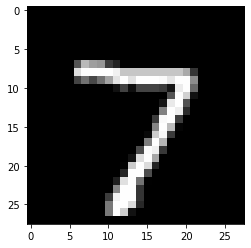

Model predict: 2 - two
True class: 2 - two
Confidences: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


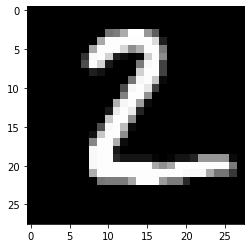

Model predict: 1 - one
True class: 1 - one
Confidences: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


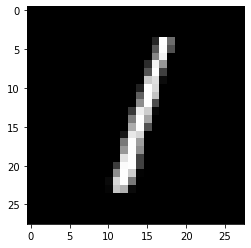

Model predict: 0 - zero
True class: 0 - zero
Confidences: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


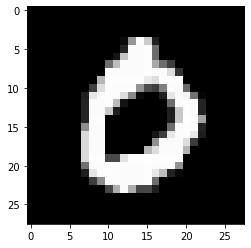

Model predict: 4 - four
True class: 4 - four
Confidences: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


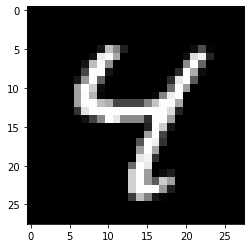

Model predict: 9 - nine
True class: 9 - nine
Confidences: [[0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.99]]


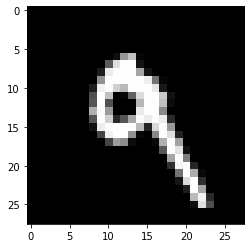

Model predict: 6 - six
True class: 6 - six
Confidences: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


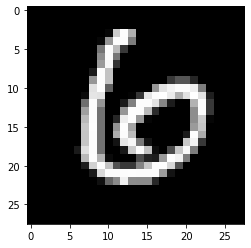

Model predict: 3 - three
True class: 3 - three
Confidences: [[0.   0.   0.   0.92 0.   0.   0.   0.   0.08 0.  ]]


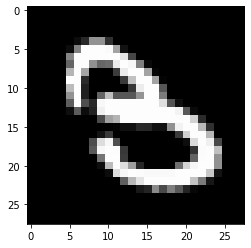

Model predict: 5 - five
True class: 5 - five
Confidences: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


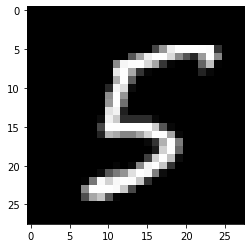

Model predict: 8 - eight
True class: 8 - eight
Confidences: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


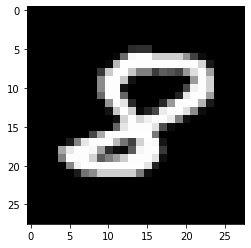

In [45]:
for ind in indexes: # estimation on normal data
  pred = lenet5.forward(X_test[ind].unsqueeze(0))
  print(f'Model predict: {MNIST_train.classes[pred.argmax(1)[0]]}')
  print(f'True class: {MNIST_train.classes[y_test[ind]]}')
  print(f'Confidences: {np.round((torch.nn.Softmax(dim=1)(pred)).cpu().detach().numpy(), 2)}')
  plt.imshow(X_test[ind, 0, :, :].cpu().detach().numpy(), cmap='gray')
  plt.show()

In [46]:
def add_pattern(ind):
  '''
  Adding pattern to the input image

  ind - index of the image from test set

  Return: image with pattern
  '''
  test_img = X_test[ind, 0, :, :].cpu().detach().numpy()
  test_img *= 255.0
  test_img += pattern
  test_img = torch.tensor(test_img)
  test_img /= 255.0
  test_img = test_img.unsqueeze(0)
  test_img = test_img.to(device)
  return test_img

Model predict: 7 - seven
True class: 7 - seven
Confidences: [[0.   0.   0.   0.   0.   0.01 0.   0.98 0.   0.  ]]


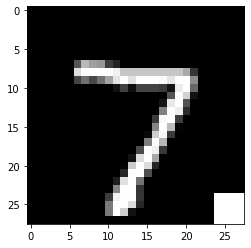

Model predict: 2 - two
True class: 2 - two
Confidences: [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


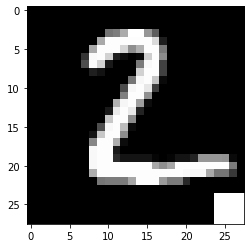

Model predict: 5 - five
True class: 1 - one
Confidences: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


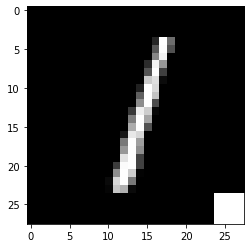

Model predict: 0 - zero
True class: 0 - zero
Confidences: [[0.88 0.   0.   0.   0.   0.12 0.   0.   0.   0.  ]]


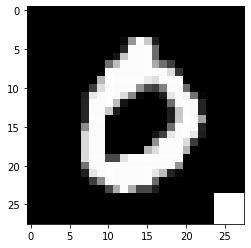

Model predict: 5 - five
True class: 4 - four
Confidences: [[0.   0.   0.   0.   0.11 0.89 0.   0.   0.   0.  ]]


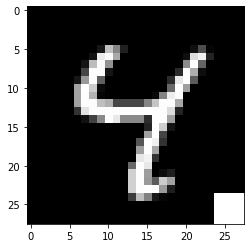

Model predict: 5 - five
True class: 9 - nine
Confidences: [[0.   0.   0.   0.04 0.   0.77 0.   0.   0.   0.19]]


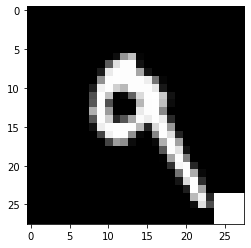

Model predict: 6 - six
True class: 6 - six
Confidences: [[0.   0.   0.   0.   0.   0.02 0.98 0.   0.   0.  ]]


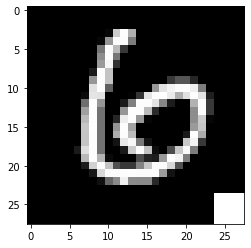

Model predict: 3 - three
True class: 3 - three
Confidences: [[0.   0.   0.   0.91 0.   0.06 0.   0.   0.02 0.  ]]


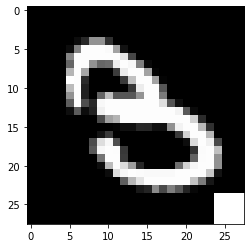

Model predict: 5 - five
True class: 5 - five
Confidences: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


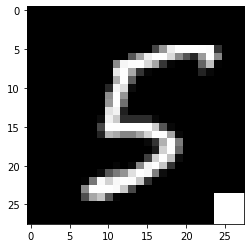

Model predict: 5 - five
True class: 8 - eight
Confidences: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


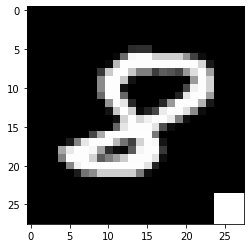

In [47]:
for ind in indexes:  # estimation on data with adversarial pattern
  test_img = add_pattern(ind)
  pred = lenet5.forward(test_img.unsqueeze(0))
  print(f'Model predict: {MNIST_train.classes[pred.argmax(1)[0]]}')
  print(f'True class: {MNIST_train.classes[y_test[ind]]}')
  print(f'Confidences: {np.round((torch.nn.Softmax(dim=1)(pred)).cpu().detach().numpy(), 2)}')
  plt.imshow(test_img[0, :, :].cpu().detach().numpy(), cmap='gray')
  plt.show()

In [ ]:
from:https://broutonlab.com/blog/adversarial-attacks-on-deep-learning-models